In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import xarray as xr
import cmocean
import matplotlib as mpl


In [2]:
LES_dirs = '../LES/'
MOM_dirs = '/work/bgr/TMP/results/'#Point to where the data from the MOM runs was stored, it could be relative to this one

#These LES are published in:
# "Interaction of Langmuir Turbulence and Inertial Currents in the Ocean Surface Boundary Layer under Tropical Cyclones" by D. Wang et al. (JPO, 2018)
# "Langmuir Turbulence Parameterization in Tropical Cyclone Conditions" by B. Reichl et al. (JPO, 2016)

# The location is arranged as 1 (500km north) and 101 (500km south) with an interval 10km per station.
# The storm translation is from east to west (so <51 is the storm relative right of track and >51 is the storm relative left of track)

#--- 5 m/s translation speed cases
#- With Langmuir
#TC021  DATA055065/LOC046  LT
#TC022  DATA055065/LOC048  LT
#TC023  DATA055065/LOC050  LT
#TC024  DATA055065/LOC051  LT
#TC025  DATA055065/LOC053  LT
#TC026  DATA055065/LOC055  LT
#TC027  DATA055065/LOC057  LT
#TC028  DATA055065/LOC059  LT
#TC029  DATA055065/LOC061  LT (missing file)
#TC030  DATA055065/LOC071  LT
#- No Langmuir
#TC031  DATA055065/LOC046  no LT
#TC032  DATA055065/LOC048  no LT
#TC033  DATA055065/LOC050  no LT
#TC034  DATA055065/LOC051  no LT
#TC035  DATA055065/LOC053  no LT
#TC036  DATA055065/LOC055  no LT
#TC037  DATA055065/LOC057  no LT
#TC038  DATA055065/LOC059  no LT
#TC039  DATA055065/LOC061  no LT
#TC040  DATA055065/LOC071  no LT

#--- 10 m/s translation speed cases
#- No Langmuir
#TC041  DATA105065/LOC046  no LT
#TC042  DATA100565/LOC048  no LT
#TC043  DATA105065/LOC050  no LT
#TC044  DATA105065/LOC051  no LT
#TC045  DATA105065/LOC053  no LT
#TC046  DATA105065/LOC055  no LT
#TC047  DATA105065/LOC057  no LT
#TC048  DATA105065/LOC059  no LT (missing file)
#TC049  DATA105065/LOC061  no LT
#TC050  DATA105065/LOC071  no LT
#TC051  DATA105065/LOC081  no LT
#- With Langmuir
#TC052  DATA105065/LOC046  LT
#TC053  DATA105065/LOC048  LT
#TC054  DATA105065/LOC050  LT
#TC055  DATA105065/LOC051  LT
#TC056  DATA105065/LOC053  LT
#TC057  DATA105065/LOC055  LT
#TC058  DATA105065/LOC057  LT
#TC059  DATA105065/LOC059  LT
#TC060  DATA105065/LOC061  LT (missing file)
#TC061  DATA105065/LOC071  LT
#TC062  DATA105065/LOC081  LT (missing file)




In [3]:
# Plotting functions

# Temp
def plot_stress(LES_time,LES_taux,LES_tauy,MOM_time,MOM_taux,MOM_tauy,title=''):
    f,ax=plt.subplots(1,2,figsize=(10,3))
    a=ax.ravel()[0]
    a.plot(LES_time,LES_taux*1000,'k-',label=r'LES $\tau_x$')
    a.plot(LES_time,LES_tauy*1000,'k--',label=r'LES $\tau_y$')
    a.plot(MOM_time,MOM_taux,'r-',label=r'MOM $\tau_x$')
    a.plot(MOM_time,MOM_tauy,'r--',label=r'MOM $\tau_y$')
    a.axhline(y=0,color='gray')
    a.set_ylim(-10.,10)
    a.set_xlim(1,2)
    a.set_ylabel(r'Surface $\vec{\tau}$ (m/s)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()
    
    a=ax.ravel()[1]
    a.plot(LES_time,np.sqrt((LES_taux*1000)**2+(LES_tauy*1000)**2),'k-',label=r'$\tau$')
    a.plot(MOM_time,np.sqrt(MOM_taux**2+MOM_tauy**2),'k--',label=r'MOM $\tau$')
    a.axhline(y=0,color='gray')
    a.set_ylim(-10.,10)
    a.set_xlim(1,2)
    a.set_ylabel(r'Surface $|\tau|$ (m/s)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()
    f.suptitle(title)
    f.tight_layout()
    
def CompT_surf(LES_temp,LES_time,MOM_temp,MOM_time,title=''):
    
    f,a=plt.subplots(1,1,figsize=(5,3))
    a.plot(LES_time,LES_temp,linewidth=2,color='k',linestyle='-',label='LES')
    a.plot(MOM_time,MOM_temp,'r',label='MOM')
    a.set_ylim(26,29.3)
    a.set_xlim(0,3)
    a.set_ylabel(r'Surface $\Theta$ ($^\circ C$)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()
    f.suptitle(title)
    f.tight_layout()

def CompT_prof(LES_temp,LES_z,MOM_temp,MOM_z,title=''):
    
    f,a=plt.subplots(1,1,figsize=(4,5))
    a.plot(LES_temp[:,0],LES_z,linewidth=2,color='k',linestyle='--')
    a.plot(LES_temp[:,-1],LES_z,linewidth=2,color='k',linestyle='-',label='LES')
    a.plot(MOM_temp[:,0],MOM_z,'r--')
    a.plot(MOM_temp[:,-1],MOM_z,'r',label='MOM')
    a.set_ylim(220,0)
    a.set_xlim(20,29.5)
    a.set_xlabel(r'$\Theta$ ($^\circ C$)',fontsize=12)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.legend()
    f.suptitle(title)
    f.tight_layout()

def CompT_Hov(LES_temp,LES_z,LES_time,MOM_temp,MOM_z,MOM_time,title=''):
    f,ax=plt.subplots(2,1,figsize=(10,5))
    levels=np.arange(26,29.5,0.25)
    cmap=cmocean.cm.thermal
    cmap.set_bad('gray')
    a=ax.ravel()[0]
    C=a.pcolormesh(LES_time,LES_z,LES_temp,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'LES $\Theta$ ($^\circ C$)',fontsize=12)
    plt.colorbar(C,ax=a)
    a=ax.ravel()[1]
    C=a.pcolormesh(MOM_time,MOM_z,MOM_temp,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(200,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'MOM $\Theta$ ($^\circ C$)',fontsize=12)
    plt.colorbar(C,ax=a)
    f.suptitle(title)
    f.tight_layout()
def CompDeltaT_Hov(LES_temp,LES_z,LES_time,MOM_temp,MOM_z,MOM_time,title=''):
    f,ax=plt.subplots(2,1,figsize=(10,5))
    levels=np.linspace(-1.9,1.9,20)
    cmap=cmocean.cm.balance
    cmap.set_bad('gray')
    a=ax.ravel()[0]
    C=a.pcolormesh(LES_time,LES_z,(LES_temp.T-LES_temp[:,0]).T,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(200,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$\Theta-\Theta_i$ ($^\circ C$)',fontsize=12)
    plt.colorbar(C,ax=a)
    a=ax.ravel()[1]
    C=a.pcolormesh(MOM_time,MOM_z,(MOM_temp.T-MOM_temp[:,0]).T,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(200,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$\Theta-\Theta_i$ ($^\circ C$)',fontsize=12)
    plt.colorbar(C,ax=a)
    f.suptitle(title)
    f.tight_layout()



def Comp_wt(LES_wt,LES_z,LES_time,MOM_wt,MOM_z,MOM_time,title=''):
    f,ax=plt.subplots(2,1,figsize=(10,5))
    levels=np.linspace(-0.0045,0.0045,10)
    cmap=cmocean.cm.balance
    cmap.set_bad('gray')
    a=ax.ravel()[0]
    cmap=cmocean.cm.balance
    cmap.set_bad('gray')
    C=a.pcolormesh(LES_time,LES_z,LES_wt,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$<tw>$ resolved (deg C m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    a=ax.ravel()[1]
    C=a.pcolormesh(MOM_time,MOM_z,MOM_wt,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(200,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$\Theta-\Theta_i$ ($^\circ C$)',fontsize=12)
    plt.colorbar(C,ax=a)
    f.suptitle(title)
    f.tight_layout()

def Comp_M(LES_time,LES_M,MOM_time,MOM_M,title=''):
    f,a=plt.subplots(1,1,figsize=(10,3))
    a.plot(LES_time,LES_M,'k-')
    a.plot(MOM_time,MOM_M,'r-')
    a.set_xlim(0,3)
    a.set_ylabel(r'<wb>_{dz}',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$<bw>_{dz}$ resolved (deg C m/s)',fontsize=12)
    f.suptitle(title)
    f.tight_layout()

def Comp_U_surf(LES_u,LES_v,LES_u_s,LES_v_s,LES_z,LES_time,MOM_u,MOM_v,MOM_u_s,MOM_v_s,MOM_z,MOM_time,title=''):
    f,ax=plt.subplots(1,3,figsize=(12,3))
    a=ax.ravel()[0]
    a.plot(LES_time,LES_u[0,:],linewidth=2,color='k',linestyle='-',label='LES u')
    a.plot(LES_time,LES_u_s[0,:],linewidth=2,color='k',linestyle='--',label='LES u Stokes')
    a.plot(MOM_time,MOM_u[0,:],linewidth=2,color='r',linestyle='-',label='MOM u')
    a.plot(MOM_time,MOM_u_s[0,:],linewidth=2,color='r',linestyle='--',label='MOM u Stokes')
    a.set_ylim(-2,2)
    a.set_xlim(0,3)
    a.set_ylabel(r'Surface $U$ (m/s)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()
    
    a=ax.ravel()[1]
    a.plot(LES_time,LES_v[0,:],linewidth=2,color='k',linestyle='-',label='LES')
    a.plot(LES_time,LES_v_s[0,:],linewidth=2,color='k',linestyle='--',label='LES Stokes')
    a.plot(MOM_time,MOM_v[0,:],linewidth=2,color='r',linestyle='-',label='MOM')
    a.plot(MOM_time,MOM_v_s[0,:],linewidth=2,color='r',linestyle='--',label='MOM Stokes')
    a.set_ylim(-2,2)
    a.set_xlim(0,3)
    a.set_ylabel(r'Surface $V$ (m/s)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()

    a=ax.ravel()[2]
    a.plot(LES_time,np.sqrt(LES_v[0,:]**2+LES_u[0,:]**2),linewidth=2,color='k',linestyle='-',label='LES')
    a.plot(LES_time,np.sqrt(LES_v_s[0,:]**2+LES_u_s[0,:]**2),linewidth=2,color='k',linestyle='--',label='LES stokes')
    a.plot(MOM_time,np.sqrt(MOM_v[0,:]**2+MOM_u[0,:]**2),linewidth=2,color='r',linestyle='-',label='MOM')
    a.plot(MOM_time,np.sqrt(MOM_v_s[0,:]**2+MOM_u_s[0,:]**2),linewidth=2,color='r',linestyle='--',label='MOM stokes')
    a.set_ylim(0,2)
    a.set_xlim(0,3)
    a.set_ylabel(r'Surface $|U+V|$ (m/s)',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.legend()

    f.suptitle(title)
    f.tight_layout()

#Currents


def Comp_U(LES_u,LES_v,LES_u_s,LES_v_s,LES_z,LES_time,MOM_u,MOM_v,MOM_u_s,MOM_v_s,MOM_z,MOM_time,title=''):
    
    
    f,ax=plt.subplots(3,3,figsize=(12,8))
    
    levels=np.linspace(-1.95,1.95,40)
    cmap=cmocean.cm.balance
    cmap.set_bad('gray')
    
    a=ax.ravel()[0]
    C=a.pcolormesh(LES_time,LES_z,LES_u,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$U$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    a=ax.ravel()[1]
    C=a.pcolormesh(MOM_time,MOM_z,MOM_u,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'MOM $U$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    a=ax.ravel()[3]
    C=a.pcolormesh(LES_time,LES_z,LES_v,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$V$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    a=ax.ravel()[4]
    C=a.pcolormesh(MOM_time,MOM_z,MOM_v,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'MOM $V$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    levels=np.linspace(-.45,.45,10)
    cmap=plt.cm.PuOr
    cmap.set_bad('gray')
    
    a=ax.ravel()[2]
    C=a.pcolormesh(LES_time,LES_z,LES_u_s,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$U_S$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    a=ax.ravel()[5]
    C=a.pcolormesh(LES_time,LES_z,LES_v_s,shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$V_S$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    levels=np.arange(0,2,0.05)
    cmap=mpl.cm.Greens
    cmap.set_bad('gray')
    
    a=ax.ravel()[6]
    C=a.pcolormesh(LES_time,LES_z,np.sqrt(LES_u**2+LES_v**2),shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'LES $(U^2+V^2)^{1/2}$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    a=ax.ravel()[7]
    C=a.pcolormesh(MOM_time,MOM_z,np.sqrt(MOM_u**2+MOM_v**2),shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'MOM $(U^2+V^2)^{1/2}$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)
    
    
    levels=np.arange(0,0.5,0.025)
    cmap=mpl.cm.Purples
    cmap.set_bad('gray')
    
    a=ax.ravel()[8]
    C=a.pcolormesh(LES_time,LES_z,np.sqrt(LES_u_s**2+LES_v_s**2),shading='nearest',norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),cmap=cmap)
    a.set_ylim(220,0)
    a.set_xlim(0,3)
    a.set_ylabel(r'Depth [m]',fontsize=12)
    a.set_xlabel(r'day',fontsize=12)
    a.set_title(r'$(U_S^2+V_S^2)^{1/2}$ (m/s)',fontsize=12)
    plt.colorbar(C,ax=a)

    f.suptitle(title)
    f.tight_layout()
    
    pass;

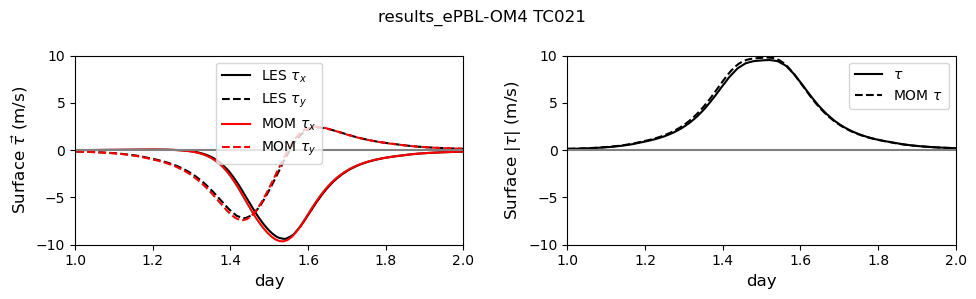

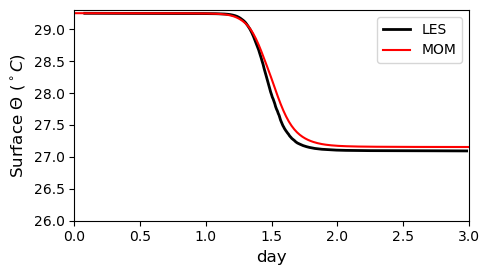

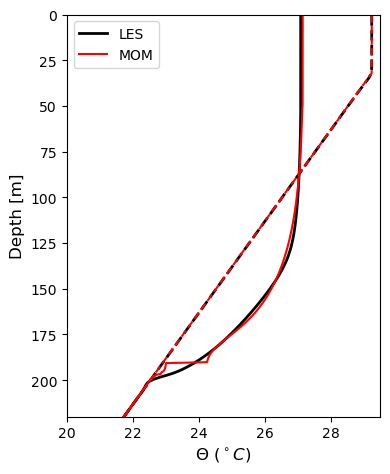

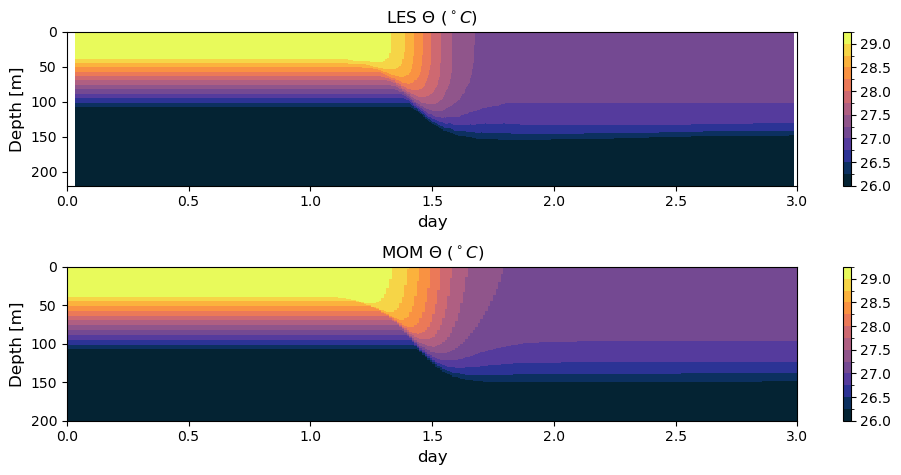

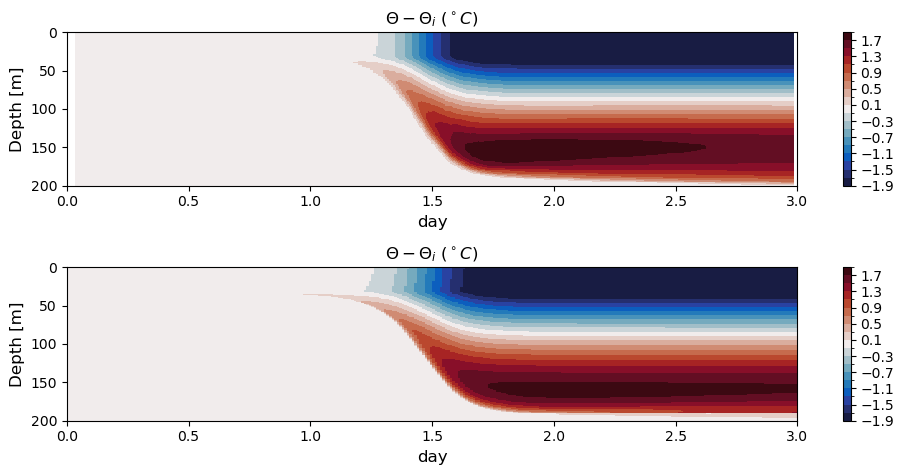

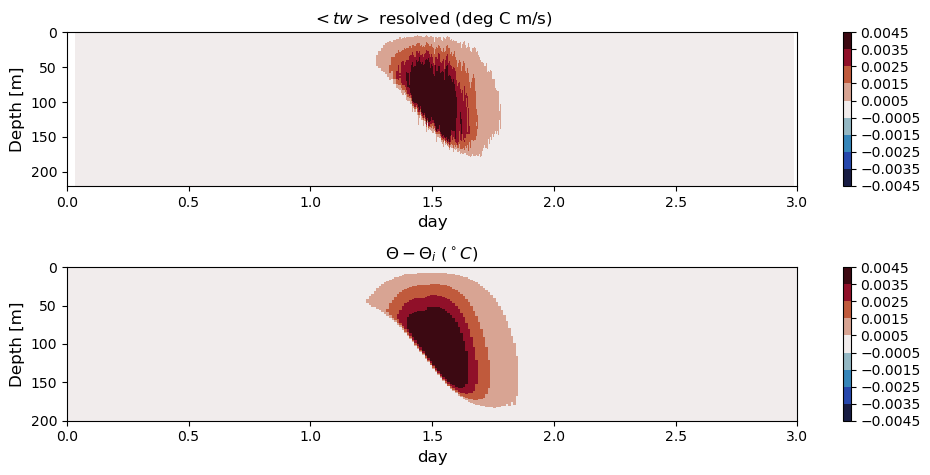

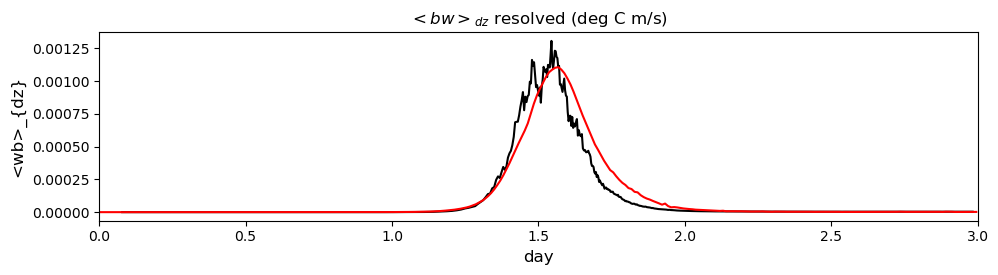

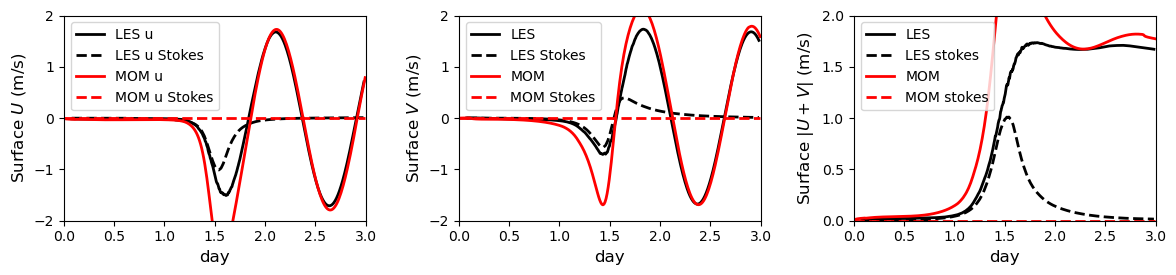

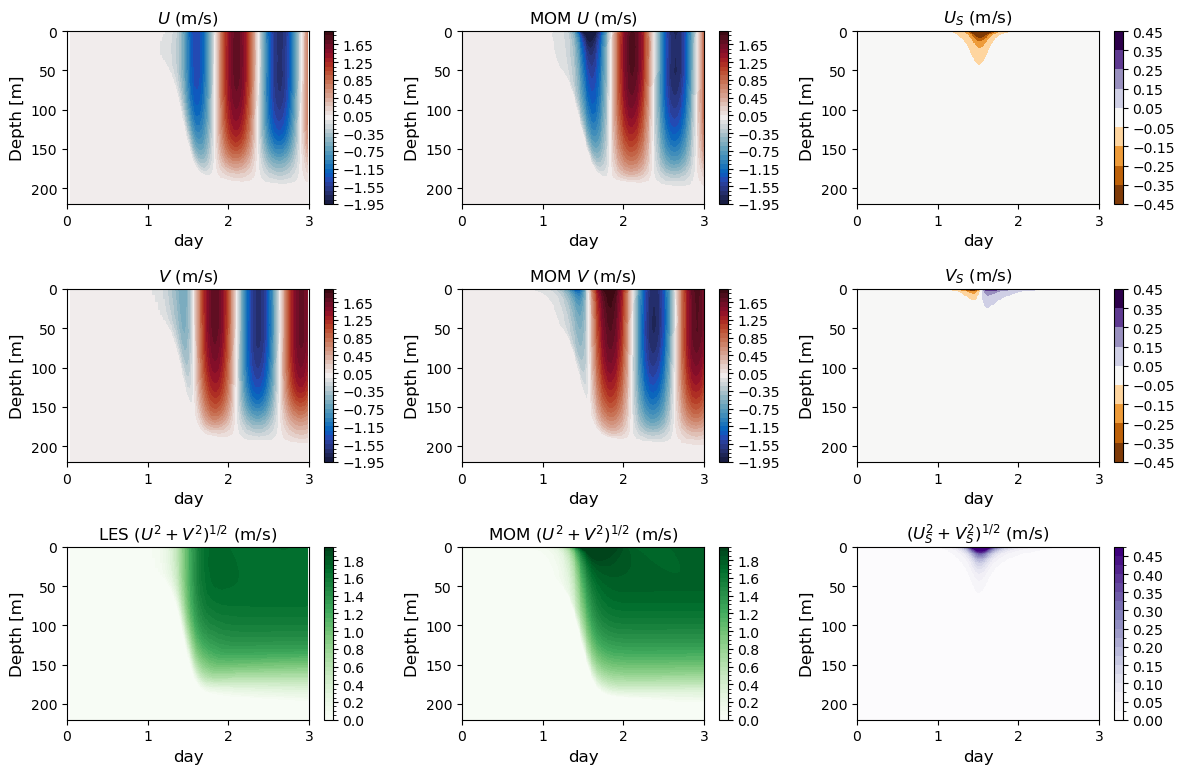

In [4]:
#Compare LES to MOM6 run

# Specify the cases
CaseList=[
    ['TC021','W65R50T05/ocean.nc.5.0E+04'], #Langmuir
    #['TC031','W65R50T05/ocean.nc.5.0E+04'], #no Langmuir
    #['TC022','W65R50T05/ocean.nc.3.0E+04'], #Langmuir
    #['TC032','W65R50T05/ocean.nc.3.0E+04'], #no Langmuir
    #['TC023','W65R50T05/ocean.nc.1.0E+04'], #Langmuir
    #['TC033','W65R50T05/ocean.nc.1.0E+04'], #no Langmuir
    #['TC024','W65R50T05/ocean.nc.0.0E+04'], #Langmuir
    #['TC034','W65R50T05/ocean.nc.0.0E+04'], #no Langmuir
    #['TC025','W65R50T05/ocean.nc.-2.0E+04'], #Langmuir
    #['TC035','W65R50T05/ocean.nc.-2.0E+04'], #no Langmuir
    #['TC026','W65R50T05/ocean.nc.-4.0E+04'], #Langmuir
    #['TC036','W65R50T05/ocean.nc.-4.0E+04'], #no Langmuir
    #['TC027','W65R50T05/ocean.nc.-6.0E+04'], #Langmuir
    #['TC037','W65R50T05/ocean.nc.-6.0E+04'], #no Langmuir
    #['TC028','W65R50T05/ocean.nc.-8.0E+04'], #Langmuir
    #['TC038','W65R50T05/ocean.nc.-8.0E+04'], #no Langmuir
    #['TC039','W65R50T05/ocean.nc.-10.0E+04'], #no Langmuir
    #['TC041','W65R50T10/ocean.nc.5.0E+04'],#Langmuir
    #['TC052','W65R50T10/ocean.nc.5.0E+04'],#no Langmuir
    #['TC042','W65R50T10/ocean.nc.3.0E+04'],#Langmuir
    #['TC053','W65R50T10/ocean.nc.3.0E+04'],#no Langmuir
    #['TC043','W65R50T10/ocean.nc.1.0E+04'],#Langmuir
    #['TC054','W65R50T10/ocean.nc.1.0E+04'],#no Langmuir
    #['TC044','W65R50T10/ocean.nc.0.0E+04'],#Langmuir
    #['TC055','W65R50T10/ocean.nc.0.0E+04'],#no Langmuir
    #['TC045','W65R50T10/ocean.nc.-2.0E+04'],#Langmuir
    #['TC056','W65R50T10/ocean.nc.-2.0E+04'],#no Langmuir
    #['TC046','W65R50T10/ocean.nc.-4.0E+04'],#Langmuir
    #['TC057','W65R50T10/ocean.nc.-4.0E+04'],#no Langmuir
    #['TC047','W65R50T10/ocean.nc.-6.0E+04'],#Langmuir
    #['TC058','W65R50T10/ocean.nc.-6.0E+04'],#no Langmuir
    #['TC059','W65R50T10/ocean.nc.-8.0E+04'],#no Langmuir
    
         ]

#Specify the name of the folder where the data is kept
for EXP in [
    #'results_JHL',
    'results_ePBL-OM4',
    #'results_ePBL-OM5',
    #'results_ePBL-CM4X',
]:
    for Case in CaseList:

        LES = sio.loadmat( LES_dirs+Case[0]+'_PROF.mat')
        LES_time=LES['t'][:].squeeze()/86400 #time in days
        zl=LES['z'].T[:].squeeze() # Cell center depth
        LES_z = zl

        MOM = xr.open_dataset(MOM_dirs+EXP+'/'+Case[1]).isel(xh=0,yh=0,xq=0,yq=0)
        #The time axis can be cumbersome to work with, this is easier but relies on the MOM output being 15 minutes
        MOM_out_time = 900 # in seconds
        MOM_time = MOM_out_time/86400*(np.arange(MOM.Time.size)+0.5)  
        MOM_z = MOM.zl.values
        MOM_zi = MOM.zi.values
        
        #The surface wind stress from the LES can be found from tau13l (x) and tau23l (y) field, which are the stress at the top of the cell.  The top cell is the top of the column.
        LES_taux=LES['tau13l'][:][:,0]
        LES_tauy=LES['tau23l'][:][:,0]
        MOM_taux = MOM.taux.values
        MOM_tauy = MOM.tauy.values
        plot_stress(LES_time,LES_taux,LES_tauy,MOM_time,MOM_taux,MOM_tauy,title=EXP+' '+Case[0])

        MOM_temp = (MOM.temp.values).T
        LES_temp = (LES['T']-273.15).T
        # Surface temperature
        CompT_surf(LES_temp[0,:],LES_time,MOM_temp[0,:],MOM_time)
        # Temperature profile
        CompT_prof(LES_temp,LES_z,MOM_temp,MOM_z)
        # Temperature profile vs time
        CompT_Hov(LES_temp,LES_z,LES_time,MOM_temp,MOM_z,MOM_time)
        # delta Temperature profile vs time
        CompDeltaT_Hov(LES_temp,LES_z,LES_time,MOM_temp,MOM_z,MOM_time)

        MOM_wt = (MOM.Tflx_dia_diff.values).T
        LES_wt = (LES['tw'][:]).T # <u'w'> resolved turbulent flux

        # delta wt profile vs time
        Comp_wt(LES_wt,LES_z,LES_time,MOM_wt,MOM_zi,MOM_time)

        alpha=-0.2
        grav=9.81
        rho0=1027
        dz = zl[2]-zl[1]
        wb=-LES['tw'][:]*alpha*grav/rho0 # <u'w'> resolved turbulent flux
        wb[wb<0]=0.0
        LES_M = np.sum(wb,axis=1)*dz
        
        dz = MOM.zi.values[2]-MOM.zi.values[1]
        wb_MOM = -MOM.Tflx_dia_diff.values*alpha*grav/rho0
        wb_MOM[wb_MOM<0]=0.0
        MOM_M = np.sum(wb_MOM,axis=1)*dz

        #Integrated mixing metric vs time
        Comp_M(LES_time,LES_M,MOM_time,MOM_M)

        LES_u=(LES['U'][:]).T # u velocity component
        LES_u_s=(LES['Us'][:]).T # u velocity component
        LES_v=(LES['V'][:]).T # u velocity component
        LES_v_s=(LES['Vs'][:]).T # u velocity component
        MOM_u=MOM.u.values.T # u velocity component
        MOM_u_s=MOM.u.values.T*0 # u velocity component No Stokes drift in these runs!
        MOM_v=MOM.v.values.T # u velocity component
        MOM_v_s=MOM.v.values.T*0 # u velocity component No Stokes drift in these runs!
        
        #Surface currents
        Comp_U_surf(LES_u,LES_v,LES_u_s,LES_v_s,LES_z,LES_time,MOM_u,MOM_v,MOM_u_s,MOM_v_s,MOM_z,MOM_time)
        #Current profile vs time
        Comp_U(LES_u,LES_v,LES_u_s,LES_v_s,LES_z,LES_time,MOM_u,MOM_v,MOM_u_s,MOM_v_s,MOM_z,MOM_time)